라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, Attention, Input
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'Test230717_tank1_lstm_crop_only-feed_no180'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

japonica_training_sensor_val_tb.set_index('mea_dt', inplace=True)
japonica_validation_sensor_val_tb.set_index('mea_dt', inplace=True)

# 시간대 자르기
time_range_1 = pd.date_range(start='03:00:00', end='05:59:00', freq='T').time
time_range_2 = pd.date_range(start='15:00:00', end='17:59:00', freq='T').time

# 03:00:00 ~ 05:59:00 시간대의 데이터 중 180개가 있는 그룹만 추출
valid_data_1 = japonica_training_sensor_val_tb.between_time(time_range_1[0], time_range_1[-1])
valid_data_1 = valid_data_1.groupby(pd.Grouper(freq='D')).filter(lambda x: len(x) == 180)

# 15:00:00 ~ 17:59:00 시간대의 데이터 중 180개가 있는 그룹만 추출
valid_data_2 = japonica_training_sensor_val_tb.between_time(time_range_2[0], time_range_2[-1])
valid_data_2 = valid_data_2.groupby(pd.Grouper(freq='D')).filter(lambda x: len(x) == 180)

# 두 시간대의 데이터를 합침
valid_data = pd.concat([valid_data_1, valid_data_2])
japonica_training_sensor_crop = valid_data.sort_index()

# 시간대 자르기
time_range_1 = pd.date_range(start='03:00:00', end='05:59:00', freq='T').time
time_range_2 = pd.date_range(start='15:00:00', end='17:59:00', freq='T').time

# 03:00:00 ~ 05:59:00 시간대의 데이터 중 180개가 있는 그룹만 추출
valid_data_1 = japonica_validation_sensor_val_tb.between_time(time_range_1[0], time_range_1[-1])
valid_data_1 = valid_data_1.groupby(pd.Grouper(freq='D')).filter(lambda x: len(x) == 180)

# 15:00:00 ~ 17:59:00 시간대의 데이터 중 180개가 있는 그룹만 추출
valid_data_2 = japonica_validation_sensor_val_tb.between_time(time_range_2[0], time_range_2[-1])
valid_data_2 = valid_data_2.groupby(pd.Grouper(freq='D')).filter(lambda x: len(x) == 180)

# 두 시간대의 데이터를 합침
valid_data = pd.concat([valid_data_1, valid_data_2])
japonica_validation_sensor_crop = valid_data.sort_index()

#인덱스 복구
japonica_training_sensor_val_tb = japonica_training_sensor_crop.reset_index()
japonica_validation_sensor_val_tb = japonica_validation_sensor_crop.reset_index()

In [6]:
#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)

In [7]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-08 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 23:59']

In [8]:
japonica_training_data

,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,,
2021-07-21 03:00:00,1,8.1,30.2,5.27,213.6,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:01:00,1,8.1,30.2,5.27,213.3,11.9,0.0,3.9,0.0,0.0
2021-07-21 03:02:00,1,8.2,30.2,5.27,213.4,11.9,0.0,4.1,0.0,0.0
2021-07-21 03:03:00,1,8.2,30.2,5.27,213.4,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:04:00,1,8.2,30.2,5.27,213.5,11.8,0.0,3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-09-08 17:55:00,1,8.1,28.9,5.42,156.1,32.1,0.0,3.9,0.0,0.0
2021-09-08 17:56:00,1,8.2,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0
2021-09-08 17:57:00,1,8.3,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0


In [9]:
time_ranges = [('03:00:00', '05:59:00'), ('15:00:00', '17:59:00')]

japonica_training_data_feed = []
japonica_validation_data_feed = []

for time_range in time_ranges:
    start_time, end_time = time_range
    print(start_time)
    print(end_time)
    filtered_training_data = japonica_training_data.between_time(start_time, end_time)
    filtered_validation_data = japonica_validation_data.between_time(start_time, end_time)
    print(len(filtered_training_data))
    
    japonica_training_data_feed.append(filtered_training_data)
    japonica_validation_data_feed.append(filtered_validation_data)


japonica_training_data = pd.concat(japonica_training_data_feed)
japonica_validation_data = pd.concat(japonica_validation_data_feed)

03:00:00
05:59:00
8280
15:00:00
17:59:00
7920


In [10]:
japonica_training_data

,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,,
2021-07-21 03:00:00,1,8.1,30.2,5.27,213.6,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:01:00,1,8.1,30.2,5.27,213.3,11.9,0.0,3.9,0.0,0.0
2021-07-21 03:02:00,1,8.2,30.2,5.27,213.4,11.9,0.0,4.1,0.0,0.0
2021-07-21 03:03:00,1,8.2,30.2,5.27,213.4,11.9,0.0,4.0,0.0,0.0
2021-07-21 03:04:00,1,8.2,30.2,5.27,213.5,11.8,0.0,3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-09-08 17:55:00,1,8.1,28.9,5.42,156.1,32.1,0.0,3.9,0.0,0.0
2021-09-08 17:56:00,1,8.2,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0
2021-09-08 17:57:00,1,8.3,28.9,5.42,156.2,31.9,0.0,4.0,0.0,0.0


In [11]:
japonica_training_features_X = japonica_training_data[['feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]


japonica_validation_features_X = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [12]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_X_chunks = japonica_training_features_X_chunks.reshape((-1, 1, 1))
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)
japonica_training_features_y_chunks = japonica_training_features_y_chunks.reshape((-1, 1, 1))

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_X_chunks = japonica_validation_features_X_chunks.reshape((-1, 1, 1))
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)
japonica_validation_features_y_chunks = japonica_validation_features_y_chunks.reshape((-1, 1, 1))

In [13]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 16200 nVar: 1
nCar: 16200 nVar: 1
nCar: 16200 nVar: 1
nCar: 16200 nVar: 1


In [14]:
japonica_training_features_X_chunks.shape

(16200, 1, 1)

LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [15]:
# LSTM 모델 생성

model = Sequential()
model.add(LSTM(128, input_shape=(1, 1), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks, japonica_training_features_y_chunks, epochs = 1000, batch_size = 32, validation_data=(japonica_validation_features_X_chunks, japonica_validation_features_y_chunks), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-23 05:07:57.976827: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 05:07:58.768652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000


2023-07-23 05:07:59.765332: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


KeyboardInterrupt: 

모델 평가

In [15]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1)) - 8.50096798
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [16]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

2023-07-23 06:31:57.024873: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 06:31:57.684389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 479 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


[[-4.72663268e-02 -1.83262378e-01 -2.80944705e-01 -5.30997254e-02
   4.97256070e-02 -7.10335299e-02 -5.46848699e-02 -8.50662775e-03
  -3.22581828e-02  3.67322266e-02 -3.75255309e-02 -1.25029758e-02
  -2.90096164e-01  1.19099924e-02 -1.74790189e-01  8.06833208e-02
  -1.71592221e-01  9.38826278e-02 -7.67420977e-02 -9.59455296e-02
  -2.74989337e-01 -7.85937458e-02  1.08334355e-01  6.76013529e-02
  -1.31007433e-01 -8.90544578e-02 -1.26921639e-01  2.73740590e-02
  -8.91414564e-03 -3.25342044e-02 -2.77821682e-02 -4.60928492e-02
  -2.07575664e-01  1.42898709e-02 -1.37847796e-01 -1.23360097e-01
  -5.04630916e-02 -1.06947906e-01 -2.21359193e-01 -1.86189801e-01
  -2.68812478e-01 -2.50464290e-01 -1.74484164e-01 -5.50884604e-02
  -5.56164794e-02 -7.98808783e-02 -2.65284717e-01 -2.23425046e-01
   7.17013180e-02 -1.82262957e-01 -1.14264928e-01 -2.35341880e-02
  -7.20075890e-02 -9.17396918e-02 -1.71415228e-02 -8.44757408e-02
  -2.61861622e-01  4.10829633e-02  2.13904418e-02 -2.29482681e-01
   1.08574

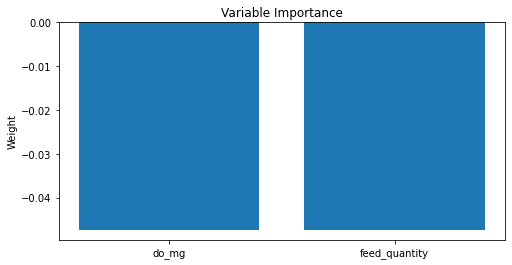

In [17]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [18]:
X = japonica_validation_features.sort_index().loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 1, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 16200 nVar: 1


In [19]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 16200 nVar: 1
nCar: 16200 nVar: 1


In [20]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

2023-07-23 06:32:02.477108: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-23 06:32:04.062777: E tensorflow/stream_executor/cuda/cuda_dnn.cc:374] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-07-23 06:32:04.063353: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at cudnn_rnn_ops.cc:1555 : Unknown: Fail to find the dnn implementation.


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential_3/lstm_7/PartitionedCall]] [Op:__inference_predict_function_3063]

Function call stack:
predict_function -> predict_function -> predict_function


In [22]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [23]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [24]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [25]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [26]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 1, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1


In [27]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 64800 nVar: 1


64800


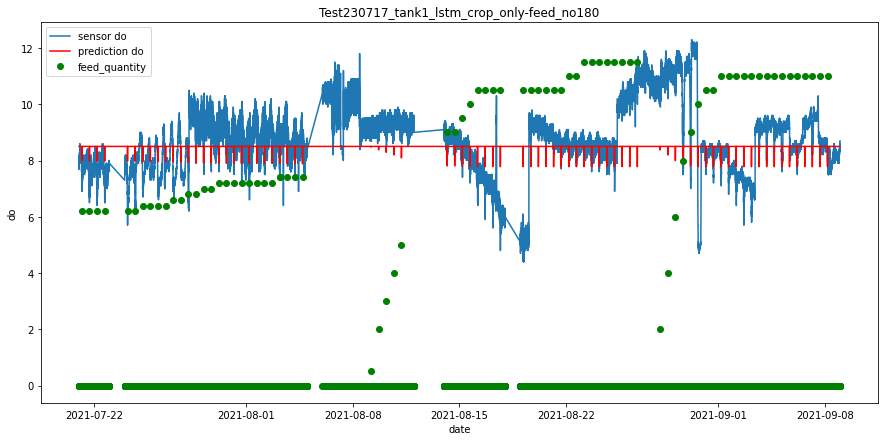

2025/2025 [==============================] - 12s 5ms/step - loss: 1.5412 - mae: 0.9249 - r_squared: -103.2856
MSE // MAE // R-squared  [1.5411567687988281, 0.9248543381690979, -103.28557586669922]


In [28]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [29]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-31 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 1, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14400 nVar: 1


In [30]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14400 nVar: 1
nCar: 14400 nVar: 1


14400


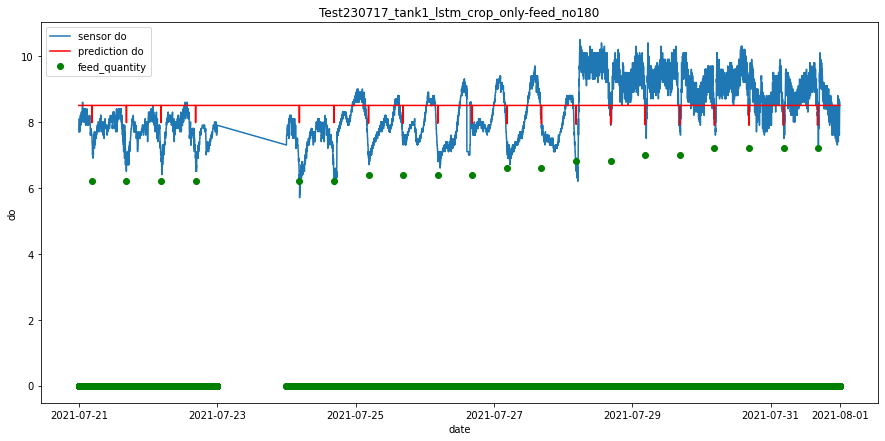

450/450 [==============================] - 3s 6ms/step - loss: 0.7518 - mae: 0.7409 - r_squared: -76.1748
MSE // MAE // R-squared  [0.7517684698104858, 0.7409378290176392, -76.17484283447266]


In [31]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [32]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-21 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 1, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1


In [33]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1


1440


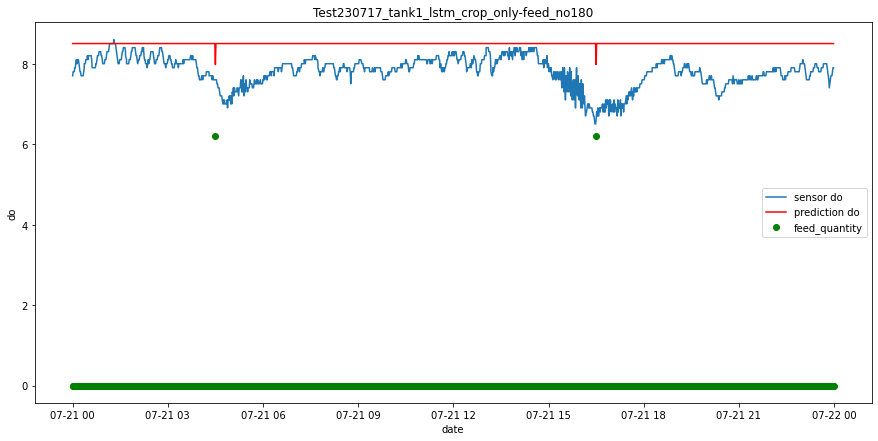

45/45 [==============================] - 0s 6ms/step - loss: 0.6081 - mae: 0.6867 - r_squared: -42.4265
MSE // MAE // R-squared  [0.6081126928329468, 0.6866990923881531, -42.426509857177734]


In [34]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [35]:
X = japonica_validation_data.loc['2021-07-21 04:30':'2021-07-21 16:29']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 1, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1


In [36]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 720 nVar: 1


720


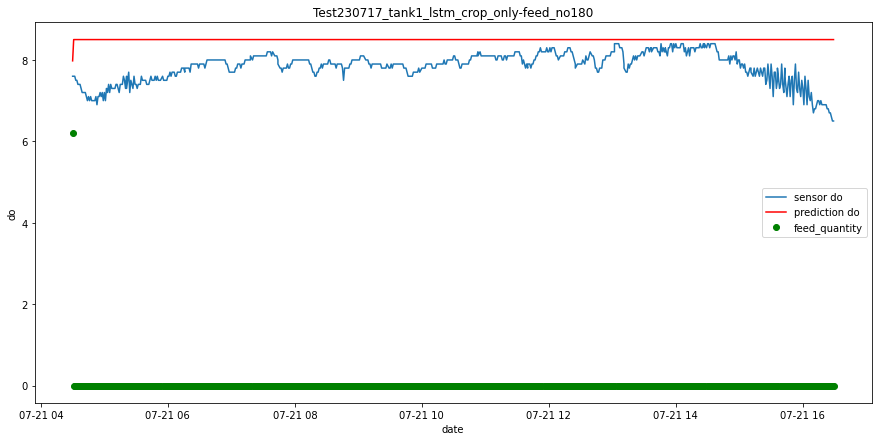

23/23 [==============================] - 0s 7ms/step - loss: 0.5601 - mae: 0.6559 - r_squared: -38.7866
MSE // MAE // R-squared  [0.560105562210083, 0.6559365391731262, -38.78659439086914]


In [37]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [38]:
japonica_validation_data.at['2021-07-21 08:00', 'feed_quantity'] = 6
X = japonica_validation_data.loc['2021-07-21 04:30':'2021-07-21 16:29']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 1, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1


In [39]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 720 nVar: 1


720


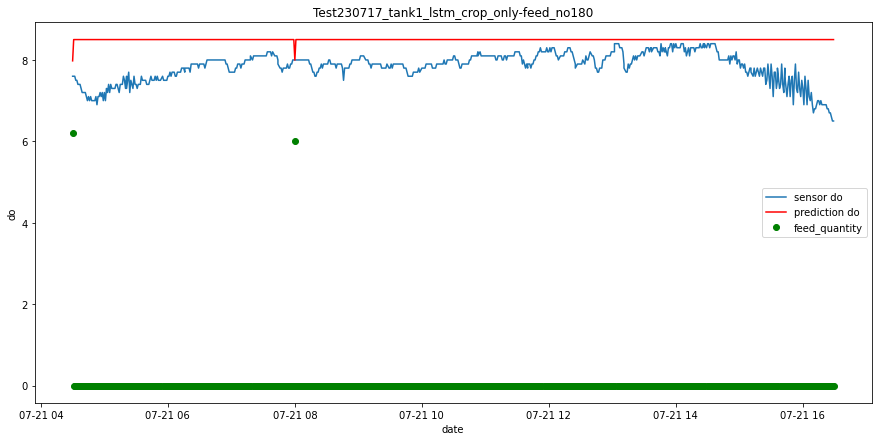

23/23 [==============================] - 0s 7ms/step - loss: 0.5598 - mae: 0.6552 - r_squared: -38.7537
MSE // MAE // R-squared  [0.5597569942474365, 0.6552456617355347, -38.753746032714844]


In [40]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

nCar: 2 nVar: 1
nCar: 2 nVar: 1
nCar: 2 nVar: 1
2


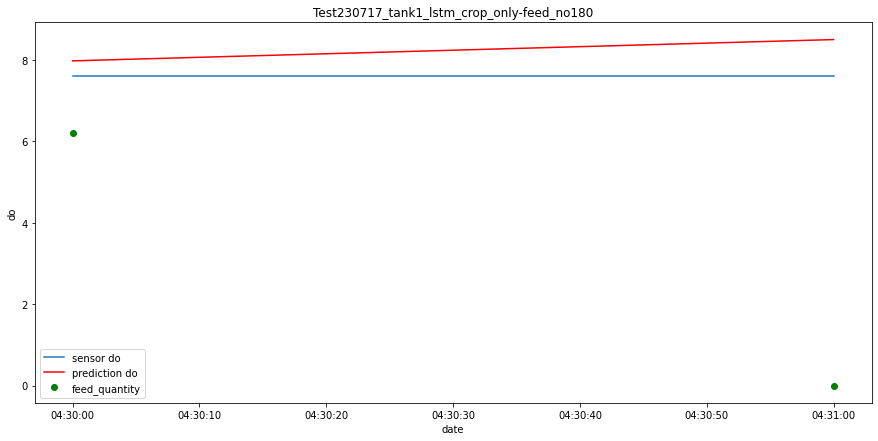

1/1 [==============================] - 0s 46ms/step - loss: 0.4774 - mae: 0.6396 - r_squared: -9547891.0000
MSE // MAE // R-squared  [0.47739461064338684, 0.6395909786224365, -9547891.0]


In [42]:
japonica_validation_data.at['2021-07-21 08:00', 'feed_quantity'] = 6
X = japonica_validation_data.loc['2021-07-21 04:30':'2021-07-21 04:31']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 1, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 1, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)